# This notebook is for Tuning, Training and Ealuatuing the SVM(Suppurt Vector Machine) model

**Includes**

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

# For model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For exporting
import joblib

**Data reading**

In [2]:
data = pd.read_csv('data/data.csv')
data.head()

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


**Dropping unneccesary columns**

In [3]:
# Drop the 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in data.columns:
	data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


Binning the age column into age groups, for better representation and prediction.

In [4]:
bins = [0, 18, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
preprocessed_data = data.copy()
categorized_age = pd.cut(preprocessed_data['age'], bins)
preprocessed_data['Categorized_age'] = categorized_age
preprocessed_data = preprocessed_data.drop('age', axis=1)
preprocessed_data.head()

,location,country,gender,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result,Categorized_age
0,104,8,1,1,0,14,31,19,12,3,1,8,1,"(60, 70]"
1,101,8,0,0,1,14,31,19,12,3,1,0,0,"(50, 60]"
2,137,8,1,0,1,14,31,19,12,3,1,13,0,"(40, 50]"
3,116,8,0,1,0,14,31,19,12,3,1,0,0,"(50, 60]"
4,116,8,1,0,0,14,31,19,12,3,1,0,0,"(50, 60]"


In [5]:
categorized_age = pd.get_dummies(preprocessed_data['Categorized_age'], prefix='Categorized_age')
preprocessed_data = pd.concat([preprocessed_data, categorized_age], axis=1)
preprocessed_data = preprocessed_data.drop('Categorized_age', axis=1)

In [6]:
X = preprocessed_data.drop('result', axis=1)
y = preprocessed_data['result']

# Display feature names
print("Feature columns:")
print(X.columns)

Feature columns:
Index(['location', 'country', 'gender', 'vis_wuhan', 'from_wuhan', 'symptom1',
       'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6',
       'diff_sym_hos', 'Categorized_age_(0, 18]', 'Categorized_age_(18, 30]',
       'Categorized_age_(30, 40]', 'Categorized_age_(40, 50]',
       'Categorized_age_(50, 60]', 'Categorized_age_(60, 70]',
       'Categorized_age_(70, 80]', 'Categorized_age_(80, 90]',
       'Categorized_age_(90, 100]'],
      dtype='object')


**Feature Scaling:** <br />
Scaling the features to ensure that all features contribute equally to the model.
To [center the data](https://en.wikipedia.org/wiki/Standard_score) (make it have zero mean and unit standard error), we subtract the mean and then divide the result by the standard deviation:
$$
x' = \frac{x-\mu}{\sigma}
$$

In [7]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for convenience
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Display the scaled features
X_scaled.head()

,location,country,gender,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,...,diff_sym_hos,"Categorized_age_(0, 18]","Categorized_age_(18, 30]","Categorized_age_(30, 40]","Categorized_age_(40, 50]","Categorized_age_(50, 60]","Categorized_age_(60, 70]","Categorized_age_(70, 80]","Categorized_age_(80, 90]","Categorized_age_(90, 100]"
0,0.698221,-1.15245,0.207592,2.120570,-0.347533,0.465755,0.401355,0.244914,0.135161,0.054668,...,2.971339,-0.137442,-0.339097,-0.388158,-0.773400,-0.453108,2.746735,-0.260901,-0.141755,-0.048196
1,0.621646,-1.15245,-1.170499,-0.471571,2.877424,0.465755,0.401355,0.244914,0.135161,0.054668,...,-0.422230,-0.137442,-0.339097,-0.388158,-0.773400,2.206977,-0.364069,-0.260901,-0.141755,-0.048196
2,1.540540,-1.15245,0.207592,-0.471571,2.877424,0.465755,0.401355,0.244914,0.135161,0.054668,...,5.092319,-0.137442,-0.339097,-0.388158,1.292991,-0.453108,-0.364069,-0.260901,-0.141755,-0.048196
3,1.004519,-1.15245,-1.170499,2.120570,-0.347533,0.465755,0.401355,0.244914,0.135161,0.054668,...,-0.422230,-0.137442,-0.339097,-0.388158,-0.773400,2.206977,-0.364069,-0.260901,-0.141755,-0.048196
4,1.004519,-1.15245,0.207592,-0.471571,-0.347533,0.465755,0.401355,0.244914,0.135161,0.054668,...,-0.422230,-0.137442,-0.339097,-0.388158,-0.773400,2.206977,-0.364069,-0.260901,-0.141755,-0.048196


#### 4. Training and Tuning the models 

**4.1 Train-validation-test split**

In [8]:
# Split the data into 'Training' and 'Temp' sets, Temp set will be further split into 'Validation' and 'Test' sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Split the 'Temp' set into 'Validation' and 'Test' sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the sets
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 604
Validation set size: 129
Test set size: 130


**model tuning and training**

In [10]:
params_svm = {      #parameter grid
    'C': [0.1, 1, 10 ],      
    'kernel': [ 'linear','sigmoid','poly']
}

svm = SVC( random_state = 42)
svm = GridSearchCV(svm, param_grid=params_svm, cv=15, scoring='recall_weighted')
svm.fit(X_train, y_train)
print(f"Best Parameters has come to be as follows: :{svm.best_params_}")
SVM_best = svm.best_estimator_

Best Parameters has come to be as follows: :{'C': 10, 'kernel': 'poly'}


#### model evaluation

SVM - Accuracy: 0.9689922480620154
SVM - Precision: 0.8461538461538461
SVM - Recall: 0.8461538461538461
SVM - F1 Score: 0.8461538461538461
SVM - ROC AUC Score: 0.9144562334217506
SVM Confusion Matrix:


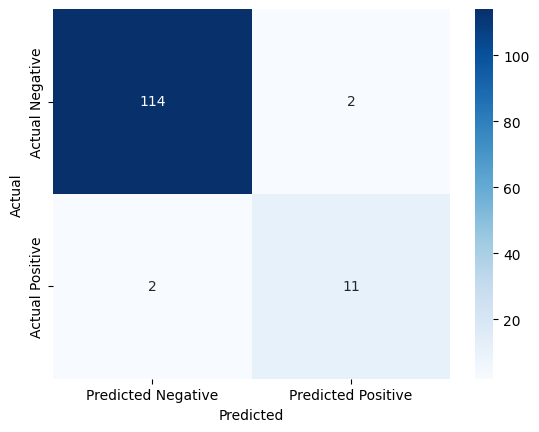


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       116
           1       0.85      0.85      0.85        13

    accuracy                           0.97       129
   macro avg       0.91      0.91      0.91       129
weighted avg       0.97      0.97      0.97       129



In [11]:
# Predict on the validation set
y_val_pred_svm = SVM_best.predict(X_val)
y_val_pred_svm_proba = SVM_best.decision_function(X_val)

# Evaluate the model
accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
precision_svm = precision_score(y_val, y_val_pred_svm)
recall_svm = recall_score(y_val, y_val_pred_svm)
f1_svm = f1_score(y_val, y_val_pred_svm)
roc_auc_svm = roc_auc_score(y_val, y_val_pred_svm)

# Display the evaluation metrics
print(f"SVM - Accuracy: {accuracy_svm}")
print(f"SVM - Precision: {precision_svm}")
print(f"SVM - Recall: {recall_svm}")
print(f"SVM - F1 Score: {f1_svm}")
print(f"SVM - ROC AUC Score: {roc_auc_svm}")

# Confusion Matrix and Classification Report
print("SVM Confusion Matrix:")
conf_matrix_svm = confusion_matrix(y_val, y_val_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nSVM Classification Report:")
print(classification_report(y_val, y_val_pred_svm))

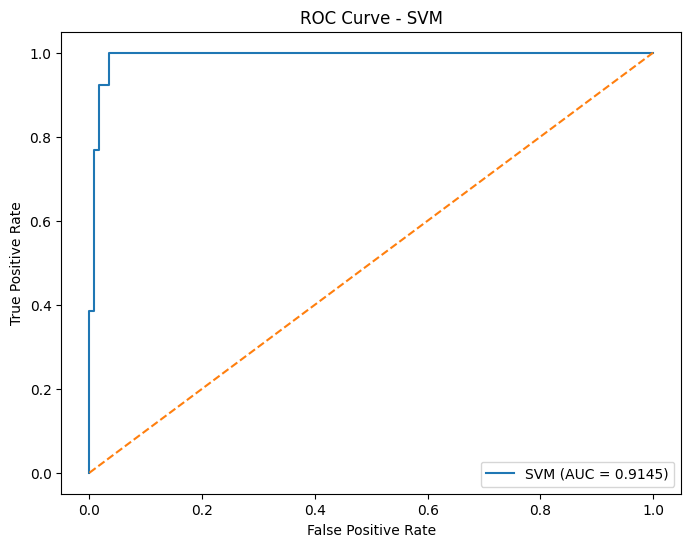

In [12]:
# Plot ROC curve for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, y_val_pred_svm_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve - SVM')
plt.show()

#### model exporting

In [14]:
# Define the directory to save the model
model_dir = 'models/SVM/'

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model_path = os.path.join(model_dir, 'SVM_model.joblib')
joblib.dump(SVM_best, model_path)
print(f"Model saved to {model_path}")



Model saved to models/SVM/SVM_model.joblib
